In [1]:
library(tidyverse)
library(qdap)
library(magrittr)
library(randomForest)
library(tidytext)
library(textstem)
library(quanteda)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.4     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: qdapDictionaries

Loading required package: qdapRegex


Attaching package: ‘qdapRegex’


The following object is masked from ‘package:dplyr’:

    explain


The following object is masked from ‘package:ggplot2’:

    %+%


Loading required package: qdapTools


Attaching package: ‘qdapTools’


The following object is masked from ‘package:dplyr’:

    id


Loading required package: RColorBrewer


Attaching package: ‘qdap’


The following object is masked from ‘package:forcats’:

    %>%


The following object is masked from ‘package:stringr’:

    %>%


The following object is masked

In [2]:
#build features based on tfidf per sentence, across sentence, across rows
#identify rarely used words
#identify groups within rows
#build groups based on topic modelling

In [3]:
train<-read.csv("../input/commonlitreadabilityprize/train.csv")
out<-read.csv("../input/commonlitreadabilityprize/test.csv")

In [4]:
train$type<-"model"
out$type<-"output"

data_prep<-train%>%
            bind_rows(out)

In [5]:
print(length(unique(train$id)))
print(length(unique(out$id)))
print(length(unique(data_prep$id)))

[1] 2834
[1] 7
[1] 2841


In [6]:
str(data_prep)

'data.frame':	2841 obs. of  7 variables:
 $ id            : chr  "c12129c31" "85aa80a4c" "b69ac6792" "dd1000b26" ...
 $ url_legal     : chr  "" "" "" "" ...
 $ license       : chr  "" "" "" "" ...
 $ excerpt       : chr  "When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an inte"| __truncated__ "All through dinner time, Mrs. Fayre was somewhat silent, her eyes resting on Dolly with a wistful, uncertain ex"| __truncated__ "As Roger had predicted, the snow departed as quickly as it came, and two days after their sleigh ride there was"| __truncated__ "And outside before the palace a great garden was walled round, filled full of stately fruit-trees, gray olives "| __truncated__ ...
 $ target        : num  -0.34 -0.315 -0.58 -1.054 0.247 ...
 $ standard_error: num  0.464 0.481 0.477 0.45 0.511 ...
 $ type          : chr  "model" "model" "model" "model" ...


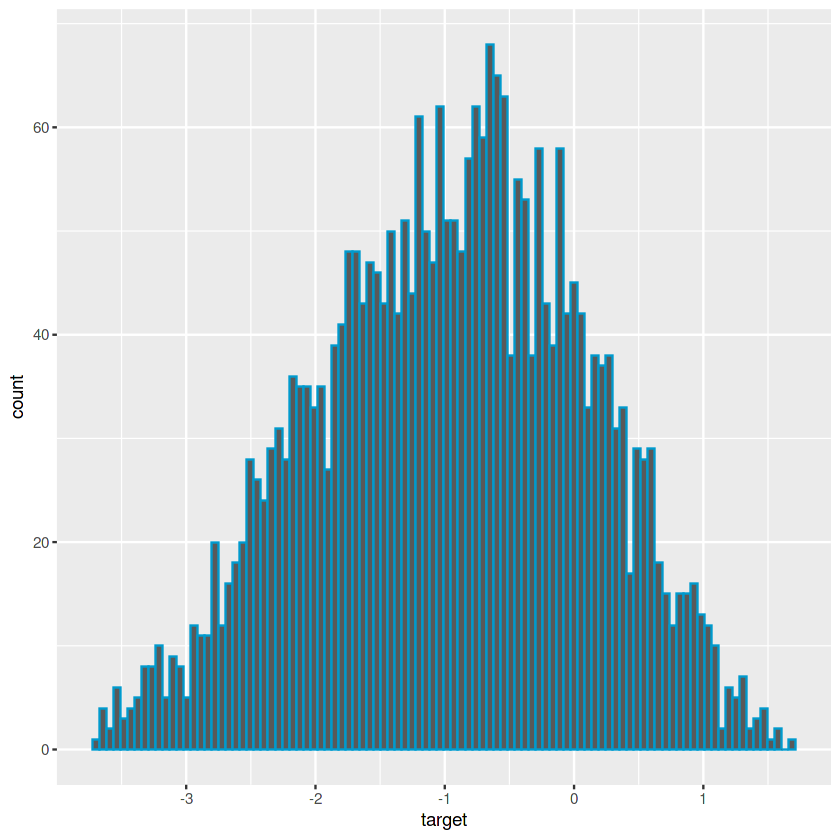

In [7]:
train%>%
ggplot(aes(x=target))+geom_histogram(bins=100,color="deepskyblue3")

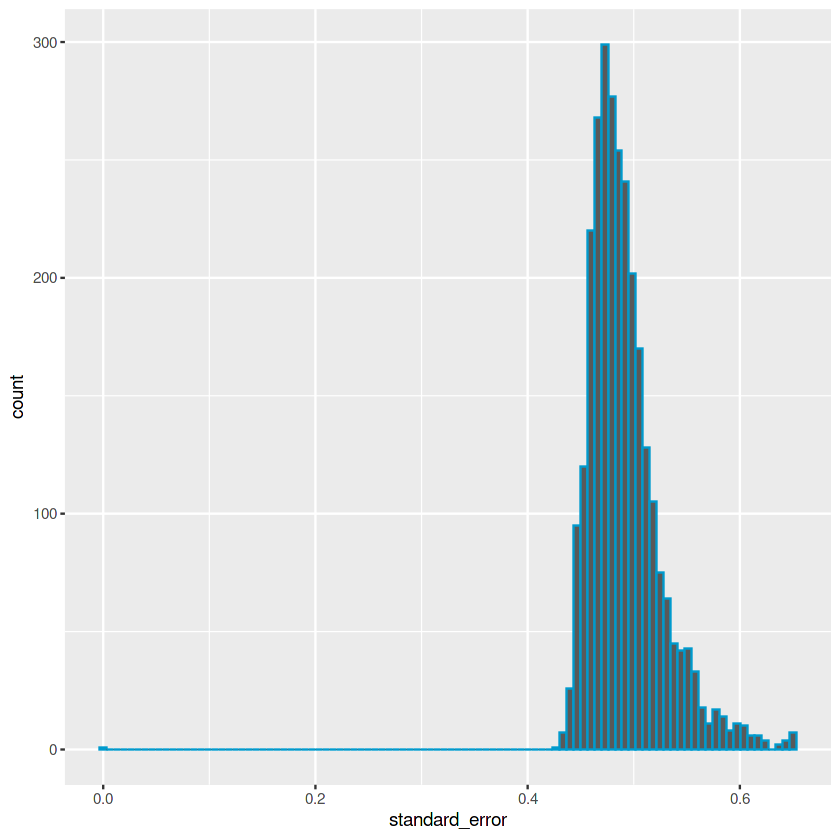

In [8]:
train%>%
ggplot(aes(x=standard_error))+geom_histogram(bins=100,color="deepskyblue3")

In [9]:
sentences<-sentSplit(data_prep,"excerpt",verbose=FALSE)


In [10]:
sentences$wordcount<-str_count(sentences$excerpt, ' ')+1
sentences$commas<-str_count(sentences$excerpt, ',')
sentences$chars<-nchar(sentences$excerpt)

head(sentences,5)

,id,tot,url_legal,license,target,standard_error,type,excerpt,wordcount,commas,chars
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<int>
1,c12129c31,1.1,,,-0.3402591,0.464009,model,"When the young people returned to the ballroom, it presented a decidedly changed appearance.",14,1,92
2,c12129c31,1.2,,,-0.3402591,0.464009,model,"Instead of an interior scene, it was a winter landscape.",10,1,56
3,c12129c31,1.3,,,-0.3402591,0.464009,model,"The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field.",22,3,128
4,c12129c31,1.4,,,-0.3402591,0.464009,model,"The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow.",22,2,131
5,c12129c31,1.5,,,-0.3402591,0.464009,model,"Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.",17,1,108


In [11]:
sentence_summ<-sentences%>%
  group_by(id)%>%
  summarise(max_word=max(wordcount),min_word=min(wordcount),avg_word=mean(wordcount),sentence_cnt=n(),total_words=sum(wordcount),avg_commas=mean(commas),sum_chars=sum(chars))%>%
    mutate(avg_chars=sum_chars/total_words)

head(sentence_summ)

id,max_word,min_word,avg_word,sentence_cnt,total_words,avg_commas,sum_chars,avg_chars
<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>
000accf7e,64,2,17.45455,11,192,1.3636364,1123,5.848958
001ef05a9,23,4,11.78571,14,165,0.5000000,959,5.812121
00589d631,18,4,11.00000,16,176,0.1250000,1050,5.965909
0060c36b9,42,6,21.33333,9,192,2.4444444,1056,5.500000
00d4d251d,22,1,11.05556,18,199,1.0000000,1040,5.226131
00e2e0148,37,4,15.90909,11,175,0.9090909,1077,6.154286


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


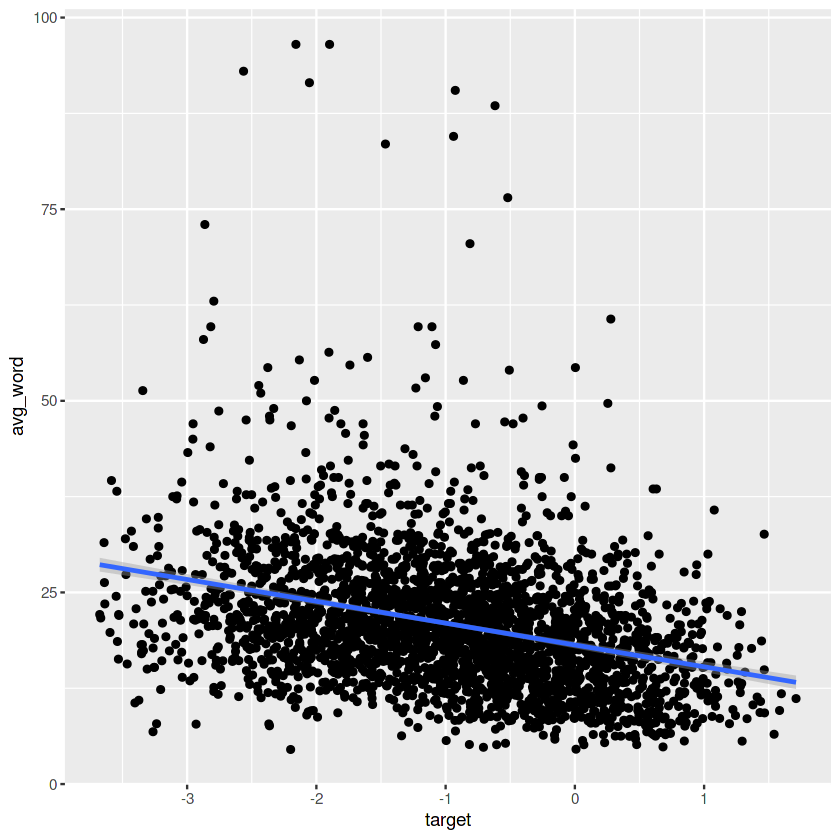

In [12]:
tocorr<-data_prep%>%
select(id,target)%>%
left_join(sentence_summ,by="id")

tocorr%>%
ggplot(aes(x=target,y=avg_word))+geom_point()+geom_smooth(method="lm")

corrplot 0.88 loaded



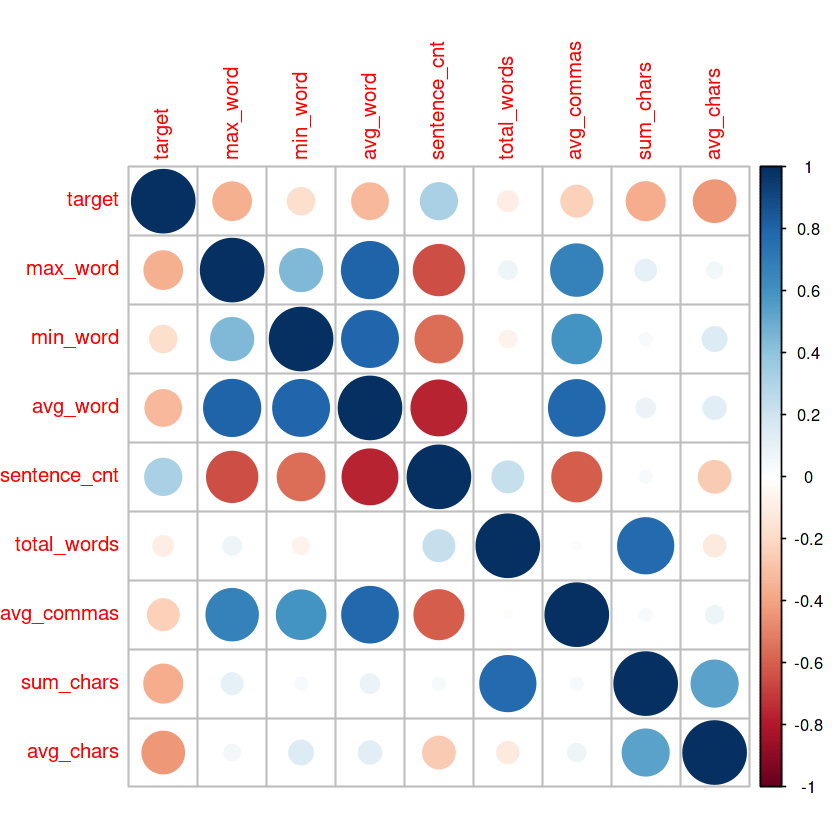

In [13]:
library(corrplot)

tocorr%>%
select(-id)%>%
na.omit()%>%
cor()%>%
corrplot()



**POS tagging**

In [14]:
POS_data<-data_prep%>%
            select(id,excerpt)



In [15]:
POS_tokens<-POS_data%>%
            unnest_tokens(word,excerpt)
            
POS_tokens$lemma<-lemmatize_words(POS_tokens$word)



In [16]:
POS_lemma<-POS_tokens%>%
            select(id,lemma)%>%
            group_by(id)%>%
            summarise(excerpt_lemm=paste(lemma,collapse=" "))%>%
            ungroup()




In [17]:
POS_model_ud<-pos(text.var=POS_lemma$excerpt_lemm,
                      progress.bar = TRUE,
                      
                    )



  |======================================================================| 100%


In [18]:
POS_data_ud<-as.data.frame(POS_model_ud$POSprop)

POS_data_ud$id<-POS_lemma$id

In [19]:
head(POS_data_ud)

,wrd.cnt,"prop,",prop.,prop$,propCC,propCD,propDT,propEX,propFW,propIN,⋯,propVBD,propVBG,propVBN,propVBP,propVBZ,propWDT,propWP,propWP$,propWRB,id
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,195,0.0000000,0.5128205,0,2.5641026,0.0000000,11.282051,0,0,13.333333,⋯,0.5128205,0,0.0000000,6.153846,0.000000,1.538462,1.0256410,0,0.5128205,000accf7e
2,167,0.0000000,0.0000000,0,0.5988024,0.5988024,12.574850,0,0,11.976048,⋯,0.5988024,0,0.5988024,6.586826,0.000000,0.000000,0.0000000,0,1.7964072,001ef05a9
3,197,0.0000000,0.0000000,0,3.0456853,0.0000000,10.152284,0,0,7.106599,⋯,0.5076142,0,1.5228426,6.091371,1.015228,0.000000,0.0000000,0,0.0000000,00589d631
4,196,0.0000000,0.0000000,0,6.6326531,0.5102041,11.734694,0,0,15.816327,⋯,0.5102041,0,0.0000000,3.061224,0.000000,0.000000,1.5306122,0,0.0000000,0060c36b9
5,217,0.4608295,0.0000000,0,6.4516129,0.4608295,12.903226,0,0,7.834101,⋯,0.0000000,0,0.9216590,5.990783,0.000000,0.000000,0.4608295,0,0.4608295,00d4d251d
6,171,0.0000000,0.0000000,0,4.6783626,0.0000000,5.847953,0,0,14.035088,⋯,0.0000000,0,0.5847953,6.432749,0.000000,1.169591,0.5847953,0,0.5847953,00e2e0148


In [20]:
POS_count_sent<-POS_data_ud%>%
                left_join(sentence_summ,by="id")

head(POS_count_sent)

,wrd.cnt,"prop,",prop.,prop$,propCC,propCD,propDT,propEX,propFW,propIN,⋯,propWRB,id,max_word,min_word,avg_word,sentence_cnt,total_words,avg_commas,sum_chars,avg_chars
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,195,0.0000000,0.5128205,0,2.5641026,0.0000000,11.282051,0,0,13.333333,⋯,0.5128205,000accf7e,64,2,17.45455,11,192,1.3636364,1123,5.848958
2,167,0.0000000,0.0000000,0,0.5988024,0.5988024,12.574850,0,0,11.976048,⋯,1.7964072,001ef05a9,23,4,11.78571,14,165,0.5000000,959,5.812121
3,197,0.0000000,0.0000000,0,3.0456853,0.0000000,10.152284,0,0,7.106599,⋯,0.0000000,00589d631,18,4,11.00000,16,176,0.1250000,1050,5.965909
4,196,0.0000000,0.0000000,0,6.6326531,0.5102041,11.734694,0,0,15.816327,⋯,0.0000000,0060c36b9,42,6,21.33333,9,192,2.4444444,1056,5.500000
5,217,0.4608295,0.0000000,0,6.4516129,0.4608295,12.903226,0,0,7.834101,⋯,0.4608295,00d4d251d,22,1,11.05556,18,199,1.0000000,1040,5.226131
6,171,0.0000000,0.0000000,0,4.6783626,0.0000000,5.847953,0,0,14.035088,⋯,0.5847953,00e2e0148,37,4,15.90909,11,175,0.9090909,1077,6.154286


**TF-IDF**

In [21]:
tf_idf<-POS_tokens%>%
        anti_join(stop_words,by="word")%>%
        group_by(id)%>%
        count(id,lemma)%>%
        bind_tf_idf(lemma,id,n)%>%
        arrange(desc(idf))%>%
        ungroup()


In [22]:
tf_idf_summ<-tf_idf%>%
                group_by(id)%>%
                summarise(avg_idf=mean(idf),avg_tf_idf=mean(tf_idf))

head(tf_idf_summ)

id,avg_idf,avg_tf_idf
<chr>,<dbl>,<dbl>
000accf7e,4.919775,0.07237769
001ef05a9,4.622325,0.11369890
00589d631,5.409356,0.10954862
0060c36b9,4.917937,0.09446219
00d4d251d,4.685085,0.10753158
00e2e0148,5.420780,0.08644349


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 7 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 7 rows containing missing values (geom_point).”


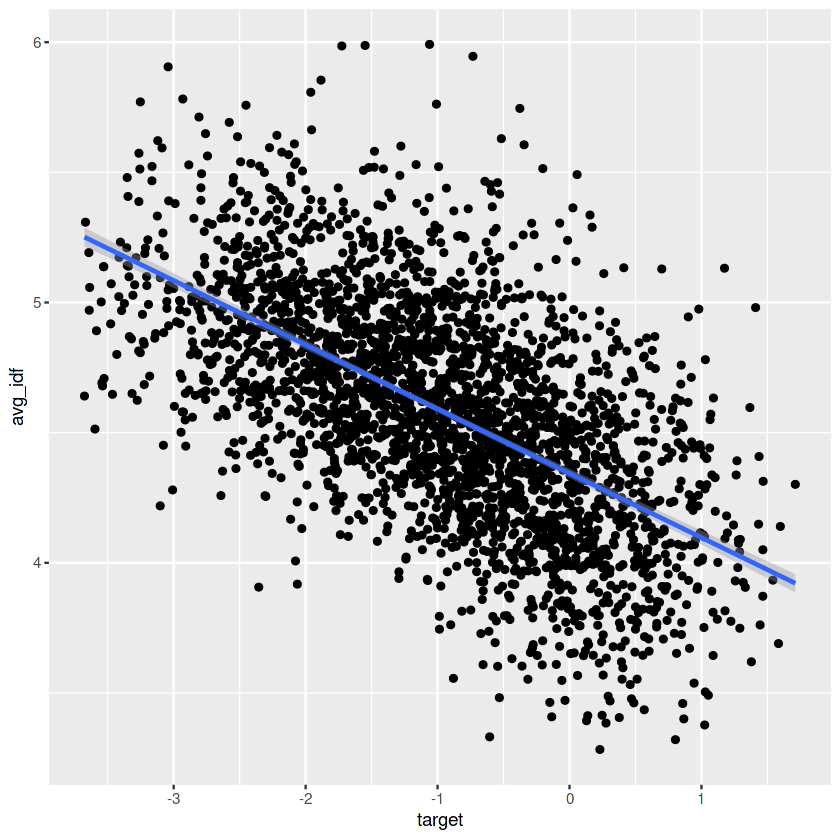

In [23]:
tocorr<-data_prep%>%
select(id,target)%>%
left_join(tf_idf_summ,by="id")

tocorr%>%
ggplot(aes(x=target,y=avg_idf))+geom_point()+geom_smooth(method="lm")

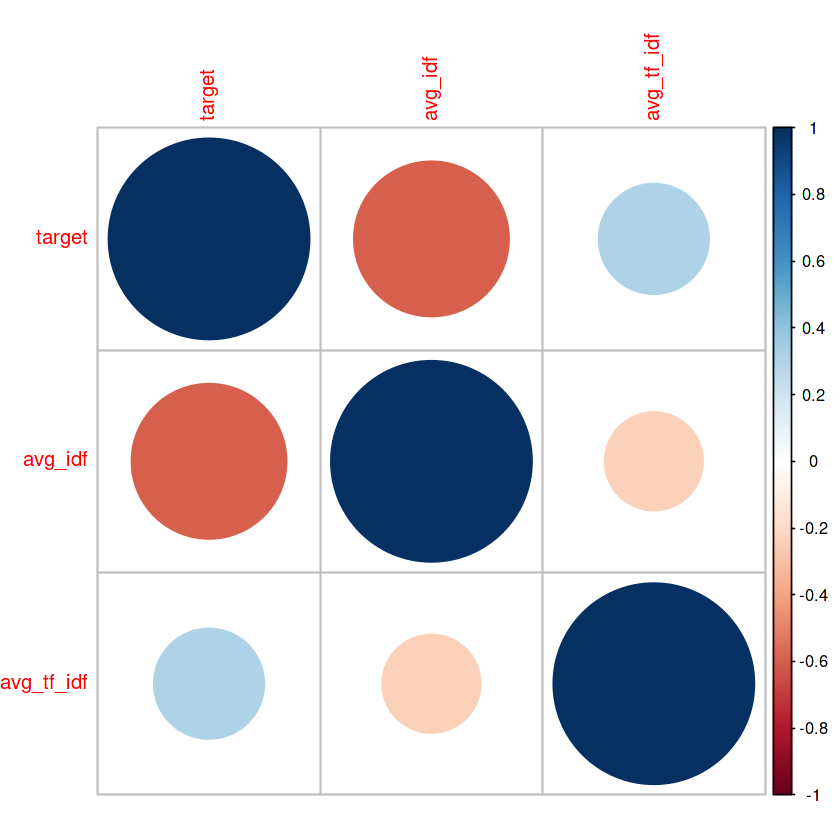

In [24]:
tocorr%>%
select(-id)%>%
na.omit()%>%
cor()%>%
corrplot()

**TF_IDF bigrams**

In [25]:
POS_bigram<-POS_data%>%
            unnest_tokens(word,excerpt,token="ngrams",n=2)
            
POS_bigram$lemma<-lemmatize_words(POS_bigram$word)

In [26]:
tf_idf_bi<-POS_bigram%>%
        group_by(id)%>%
        count(id,lemma)%>%
        bind_tf_idf(lemma,id,n)%>%
        ungroup()

tf_idf_bi_summ<-tf_idf_bi%>%
                group_by(id)%>%
                summarise(sum_idf_bi=sum(idf),sum_tf_idf_bi=sum(tf_idf),avg_idf_bi=mean(idf),avg_tf_idf_bi=mean(tf_idf))

head(tf_idf_bi_summ)

id,sum_idf_bi,sum_tf_idf_bi,avg_idf_bi,avg_tf_idf_bi
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
000accf7e,1252.6049,6.588763,6.627539,0.03486118
001ef05a9,989.6432,6.420343,6.468256,0.04196302
00589d631,1217.4438,6.810036,6.917294,0.03869339
0060c36b9,1114.2538,5.946892,6.022993,0.03214536
00d4d251d,1157.8123,6.495839,6.396753,0.03588861
00e2e0148,1126.6054,6.855540,6.869545,0.04180207


In [27]:
POS_count_sent_tf<-POS_count_sent%>%
                    left_join(tf_idf_summ,by="id")%>%
                    left_join(tf_idf_bi_summ,by="id")

In [28]:
length(POS_count_sent_tf$id)
length(train$id)

[1] 2841

[1] 2834

In [29]:
Regression_data<-train%>%
                select(id,target)%>%
                left_join(POS_count_sent,by="id")%>%
                left_join(tf_idf_summ,by="id")%>%
                left_join(tf_idf_bi_summ,by="id")%>%
                select(avg_commas,avg_chars,avg_idf_bi,avg_tf_idf_bi,avg_tf_idf,avg_idf,avg_word,min_word,max_word,propWRB,propWP,propWDT,propVBZ,propVBP,propVBN,propVBG,propVBD,propVB,propUH,propTO,propSYM,propRP,propRBS,propRBR,propRB,propPRP,propPOS,propPDT,propNNS,propNNPS,propNNP,propNN,propMD,propLS,propJJS,propJJR,propJJ,propIN,propFW,propEX,propDT,propCD,propCC,target)


In [30]:
set.seed(111)
split<-caTools::sample.split(Regression_data$target,0.7)
test<-Regression_data[which(split==0),]
training<-Regression_data[which(split==1),]

head(training)

,avg_commas,avg_chars,avg_idf_bi,avg_tf_idf_bi,avg_tf_idf,avg_idf,avg_word,min_word,max_word,propWRB,⋯,propJJS,propJJR,propJJ,propIN,propFW,propEX,propDT,propCD,propCC,target
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.272727,5.486034,6.143935,0.03545187,0.07045011,4.581161,16.27273,5,30,0.5524862,⋯,0,0.0000000,7.734807,11.049724,0,0,17.679558,2.2099448,6.077348,-0.3402591
3,1.416667,5.343373,6.549681,0.03969871,0.09054409,4.669899,13.83333,3,31,0.0000000,⋯,0,0.5813953,6.976744,9.883721,0,0,6.976744,0.5813953,5.813953,-0.5801180
4,4.600000,5.518293,6.533156,0.03961628,0.06540560,4.449144,32.80000,11,58,0.0000000,⋯,0,0.0000000,14.970060,14.970060,0,0,11.377246,1.7964072,8.982036,-1.0540134
5,2.600000,4.891156,5.568247,0.07212308,0.23377314,3.414441,29.40000,20,35,0.0000000,⋯,0,0.0000000,17.880795,11.258278,0,0,20.529801,1.3245033,6.622517,0.2471974
6,2.142857,5.588957,6.375910,0.04160418,0.09520418,4.561707,23.28571,3,42,0.6097561,⋯,0,0.0000000,10.365854,15.853659,0,0,9.146341,1.2195122,5.487805,-0.8618086
7,1.222222,5.872832,6.395328,0.03798952,0.07487364,4.869553,19.22222,1,42,1.7045455,⋯,0,0.0000000,12.500000,15.909091,0,0,10.795455,0.5681818,3.977273,-1.7590614


In [31]:
m1<-lm(target~.,data=training)

#MASS::stepAIC(m1)

m2<-lm(formula = target ~ avg_commas + avg_chars + avg_idf_bi + avg_tf_idf_bi + 
    avg_idf + min_word + max_word + propWDT + propVBD + propTO + 
     propRP + propNNS + propNN + propIN + propFW + propDT + 
    propCD, data = training)

summary(m2)


Call:
lm(formula = target ~ avg_commas + avg_chars + avg_idf_bi + avg_tf_idf_bi + 
    avg_idf + min_word + max_word + propWDT + propVBD + propTO + 
    propRP + propNNS + propNN + propIN + propFW + propDT + propCD, 
    data = training)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5224 -0.4804  0.0041  0.4794  2.5131 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    9.652099   0.475402  20.303  < 2e-16 ***
avg_commas    -0.050102   0.027358  -1.831   0.0672 .  
avg_chars     -0.300901   0.064048  -4.698 2.81e-06 ***
avg_idf_bi    -0.814982   0.106545  -7.649 3.15e-14 ***
avg_tf_idf_bi 24.263041   3.724471   6.514 9.24e-11 ***
avg_idf       -0.765941   0.057242 -13.381  < 2e-16 ***
min_word       0.005378   0.003003   1.791   0.0734 .  
max_word      -0.011799   0.001584  -7.449 1.40e-13 ***
propWDT       -0.139756   0.026052  -5.365 9.07e-08 ***
propVBD        0.062959   0.038078   1.653   0.0984 .  
propTO        -0.053763   0.013112  

In [32]:
rf <- randomForest(target ~ ., data = training, ntree=600,
                         importance = TRUE, na.action = na.omit)



Call:
 randomForest(formula = target ~ ., data = training, ntree = 600,      importance = TRUE, na.action = na.omit) 
               Type of random forest: regression
                     Number of trees: 600
No. of variables tried at each split: 14

          Mean of squared residuals: 0.5614303
                    % Var explained: 48.31


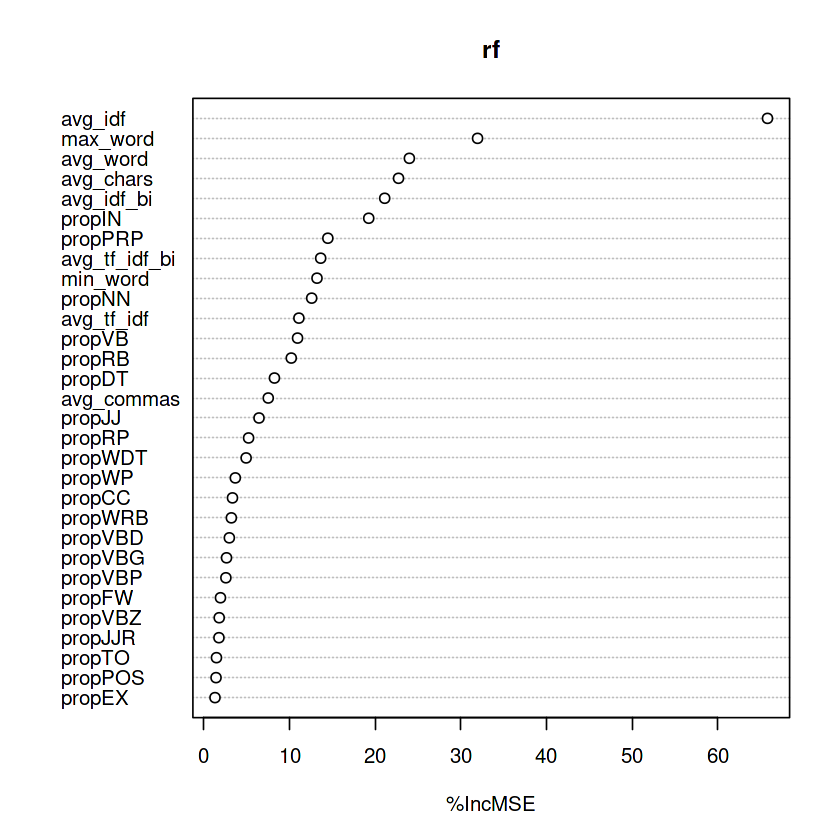

In [33]:
print(rf)
varImpPlot(rf, type=1)

In [34]:
preds_test<-predict(rf,test)

Metrics::rmse(preds_test, test$target)

[1] 0.7091178

In [35]:
out_set<-POS_count_sent_tf%>%
        ungroup()%>%
        filter(id %in% (out$id))

out_set<-out_set
#%>%
 #       select(-id)

head(out_set,9)

,wrd.cnt,"prop,",prop.,prop$,propCC,propCD,propDT,propEX,propFW,propIN,⋯,total_words,avg_commas,sum_chars,avg_chars,avg_idf,avg_tf_idf,sum_idf_bi,sum_tf_idf_bi,avg_idf_bi,avg_tf_idf_bi
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,179,0,0.000000,0,2.234637,3.3519553,10.614525,0.0000000,0.0000000,13.966480,⋯,179,1.4285714,1117,6.240223,5.214051,0.09814855,1052.2393,6.582466,6.617857,0.04139916
2,178,0,0.000000,0,5.617978,0.5617978,8.426966,0.5617978,1.1235955,10.112360,⋯,174,1.2307692,926,5.321839,4.783192,0.08902795,1060.9518,6.215080,6.277821,0.03677562
3,167,0,0.000000,0,4.191617,0.5988024,7.784431,0.0000000,0.0000000,14.371257,⋯,166,2.3333333,1057,6.367470,5.068677,0.07296906,1119.2275,6.768156,6.824558,0.04126924
4,153,0,0.000000,0,5.228758,0.6535948,5.228758,0.0000000,0.0000000,14.379085,⋯,136,0.5555556,735,5.404412,5.009196,0.19304789,854.4224,6.790592,6.835379,0.05432474
5,161,0,1.242236,0,5.590062,2.4844720,4.968944,0.0000000,0.0000000,9.316770,⋯,161,0.4000000,880,5.465839,3.876426,0.08055015,991.1981,6.339712,6.394826,0.04090137
6,149,0,0.000000,0,2.684564,0.6711409,13.422819,0.0000000,0.6711409,15.436242,⋯,149,0.7500000,761,5.107383,4.153555,0.09010498,862.5437,5.929382,6.031774,0.04146421
7,185,0,0.000000,0,4.864865,0.0000000,10.810811,1.0810811,0.0000000,8.648649,⋯,181,0.8333333,948,5.237569,4.429412,0.10172873,1038.6709,6.114536,6.145982,0.03618069


In [36]:
rf_preds<-predict(rf,out_set)

submission<-data.frame(id=out_set$id,target=rf_preds)

head(submission,7)

,id,target
,<chr>,<dbl>
1,04caf4e0c,-1.9444859
2,0df072751,-0.7453196
3,0e63f8bea,-1.8581159
4,12537fe78,-0.9659339
5,965e592c0,0.1416307
6,c0f722661,-0.2984567
7,f0953f0a5,-0.3604471


In [37]:
write.csv(submission, "submission.csv", row.names=FALSE)